In [ ]:
%matplotlib widget

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import display

from juart.analytical_phantoms.ellipsoids import Ellipsoid, Geometry, Tissue

# Create 3D Ellipsoid

In [2]:
tissue_params = {
    "spin": 1e10,
    "t1fitA": 0.324,
    "t1fitC": 0.137,
    "t2": 0.07,
    "chi": -7.5e-6,
    "tissue": "scalp",
}

geom_params = {
    "center": [0, 0, 0],
    "axes": [0.08, 0.1, 0.1],
    "angle": 0,
}

In [3]:
geom = Geometry(
    center=geom_params["center"], axes=geom_params["axes"], angle=geom_params["angle"]
)

tissue = Tissue(
    spin_density=tissue_params["spin"],
    t1_fitA=tissue_params["t1fitA"],
    t1_fitC=tissue_params["t1fitC"],
    t2=tissue_params["t2"],
    chi=tissue_params["chi"],
    type=tissue_params["tissue"],
)

ellipsoid = Ellipsoid(
    geometry=geom,
    tissue=tissue,
    counter=0,
)

seq_type = "GRE"
seq_params = {
    "tr": 2,
    "flip": np.deg2rad(30),
    "b0": 3,
    "gamma": 42.567e6,
}

In [4]:
# Get signal data for kspace
matrix = torch.tensor([256, 256, 256])
fov = torch.tensor([0.2, 0.2, 0.2])
kmax = 1 / fov * matrix / 2

# Create a k-space trajectory as a grid
kx = torch.linspace(-kmax[0], kmax[0], matrix[0])
ky = torch.linspace(-kmax[1], kmax[1], matrix[1])
kz = torch.linspace(-kmax[2], kmax[2], matrix[2])
kx, ky, kz = torch.meshgrid(kx, ky, kz, indexing="ij")
ktraj = torch.stack((kx.flatten(), ky.flatten(), kz.flatten()), dim=1).T

# Times are 3D epi like
t = torch.arange(matrix[0] * matrix[1]) * 1e-6
t = t.repeat(matrix[2])
seq_params["te"] = t

# Simulate signal
data = ellipsoid.get_ksp_signal(ktraj, seq_type=seq_type, seq_params=seq_params)

# Reshape data to grid
data = data.reshape(matrix[0], matrix[1], matrix[2], 1)

# Fourier transfrom to image space
image = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(data), dim=(0, 1, 2)))

/tmp/ipykernel_59541/3011789725.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  shw = plt.imshow(np.abs(image[..., z0, 0]), cmap="gray")


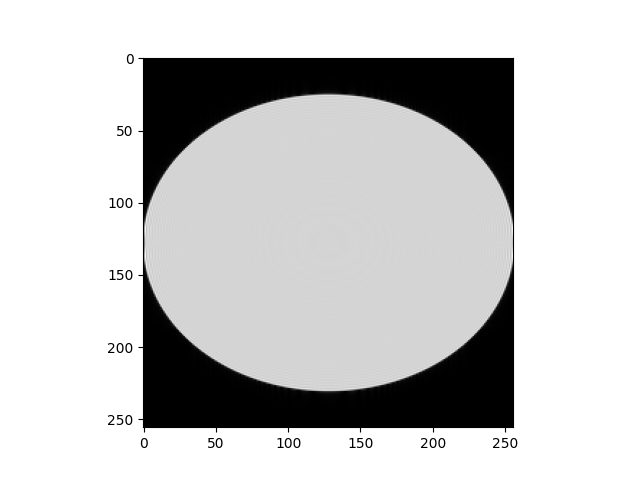

In [5]:
z0 = image.shape[2] // 2

plt.figure()
shw = plt.imshow(np.abs(image[..., z0, 0]), cmap="gray")

# Create 2D Ellipsoid

In [6]:
tissue_params = {
    "spin": 10e6,
    "t1fitA": 0.324,
    "t1fitC": 0.137,
    "t2": 0.07,
    "chi": -7.5e-6,
    "tissue": "scalp",
}

geom_params = {
    "center": [0, 0],
    "axes": [0.05, 0.1],
    "angle": 0,
}

In [7]:
geom = Geometry(
    center=geom_params["center"], axes=geom_params["axes"], angle=geom_params["angle"]
)

tissue = Tissue(
    spin_density=tissue_params["spin"],
    t1_fitA=tissue_params["t1fitA"],
    t1_fitC=tissue_params["t1fitC"],
    t2=tissue_params["t2"],
    chi=tissue_params["chi"],
    type=tissue_params["tissue"],
)

ellipsoid = Ellipsoid(
    geometry=geom,
    tissue=tissue,
    counter=0,
)

seq_type = "GRE"
seq_params = {
    "tr": 2,
    "flip": np.deg2rad(30),
    "b0": 3,
    "gamma": 42.567e6,
}

In [8]:
# Get signal data for kspace
matrix = torch.tensor([256, 256])
fov = torch.tensor([0.2, 0.2])
kmax = 1 / fov * matrix / 2

# Create a k-space trajectory as a grid
kx = torch.linspace(-kmax[0], kmax[0], matrix[0])
ky = torch.linspace(-kmax[1], kmax[1], matrix[1])

kx, ky = torch.meshgrid(kx, ky, indexing="ij")
ktraj = torch.stack((kx.flatten(), ky.flatten()), dim=1).T

# Times are 3D epi like
t = torch.arange(matrix[0] * matrix[1]) * 1e-6
seq_params["te"] = [0]

# Simulate signal
data = ellipsoid.get_kspace_geometry(ktraj)

# Reshape data to grid
data = data.reshape(matrix[0], matrix[1], 1)

# Fourier transfrom to image space
image = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(data)))

/tmp/ipykernel_59541/1149500188.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  shw = plt.imshow(np.abs(image[...,]), cmap="gray")


IntSlider(value=0, description='Echo:', max=1)

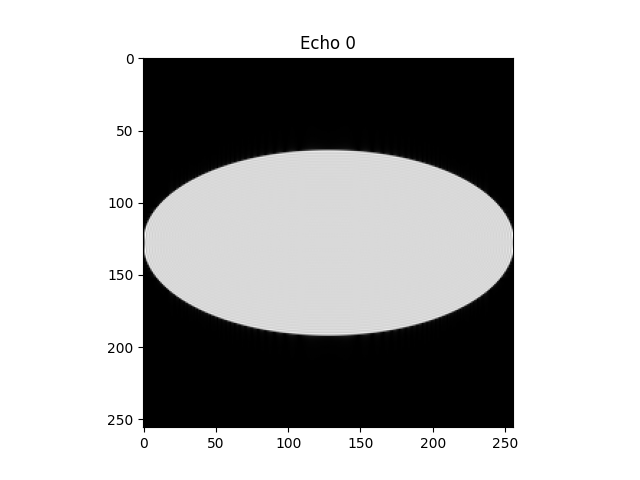

In [9]:
plt.figure()
shw = plt.imshow(np.abs(image[...,]), cmap="gray")


def update_slice(e):
    shw.set_data(np.abs(image[..., e]))
    plt.title(f"Echo {e}")


e_slider = widgets.IntSlider(value=0, min=0, max=1, step=1, description="Echo:")

widgets.interactive(update_slice, e=e_slider)

display(e_slider)